# Open Source RAG - Leveraging Hugging Face Endpoints through LangChain

In the following notebook we will dive into the world of Open Source models hosted on Hugging Face's [inference endpoints](https://ui.endpoints.huggingface.co/).

The notebook will be broken into the following parts:

- 🤝 Breakout Room #2:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating LangChain components powered by the endpoints
  4. Creating a simple RAG pipeline with [LangChain v0.2.0](https://blog.langchain.dev/langchain-v02-leap-to-stability/)

## Task 1: Install required libraries

Now we've got to get our required libraries!

We'll start with our `langchain` and `huggingface` dependencies.



In [1]:
!pip install -qU langchain-huggingface langchain-community faiss-cpu

## Task 2: Set Environment Variables

We'll need to set our `HF_TOKEN` so that we can send requests to our protected API endpoint.

We'll also set-up our OpenAI API key, which we'll leverage later.



In [4]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HuggingFace Write Token: ")

## Task 3: Creating LangChain components powered by the endpoints

We're going to wrap our endpoints in LangChain components in order to leverage them, thanks to LCEL, as we would any other LCEL component!

### HuggingFaceEndpoint for LLM

We can use the `HuggingFaceEndpoint` found [here](https://github.com/langchain-ai/langchain/blob/master/libs/community/langchain_community/llms/huggingface_endpoint.py) to power our chain - let's look at how we would implement it.

In [5]:
YOUR_LLM_ENDPOINT_URL = "https://e5kcrr0a3r3eaqfk.us-east-1.aws.endpoints.huggingface.cloud"

In [6]:
from langchain_community.llms import HuggingFaceEndpoint

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
    huggingfacehub_api_token=os.environ["HF_TOKEN"]
)

/var/folders/9b/w4m3gwfn51z3r910zg6b_k4c0000gn/T/ipykernel_59747/1258114758.py:3: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  hf_llm = HuggingFaceEndpoint(
/opt/miniconda3/envs/w8-d1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /Users/gmedrano/.cache/huggingface/token
Login successful


Now we can use our endpoint like we would any other LLM!

In [7]:
hf_llm.invoke("Hello, how are you?")

" I am doing well, thanks for asking. I have been busy with work and other things, but I always make time for my blog. Today, I want to talk about something that is very important to me: mental health.\nAs you may know, I have been open about my struggles with anxiety and depression in the past. It's not something that I take lightly, and I want to use my platform to help others who may be struggling. Mental health is just as important as physical health, and it's something that we should all prioritize.\nThere are many things that we can do to take care of our mental health, but today I want to focus on one thing: self-care. Self-care is not just about taking a relaxing bath or getting a massage (although those things can be nice too!). It's about making conscious choices to take care of your mind, body, and spirit.\nHere are some self-care ideas that you might find helpful:\n1. Practice mindfulness: Mindfulness is the practice of being present in the moment, without judgment. You can

Now we can add a RAG-style prompt using Llama 3 Instruct's prompt templating!

In [8]:
from langchain_core.prompts import PromptTemplate

RAG_PROMPT_TEMPLATE = """\
<|start_header_id|>system<|end_header_id|>
You are a helpful assistant. You answer user questions based on provided context. If you can't answer the question with the provided context, say you don't know.<|eot_id|>

<|start_header_id|>user<|end_header_id|>
User Query:
{query}

Context:
{context}<|eot_id|>

<|start_header_id|>assistant<|end_header_id|>
"""

rag_prompt = PromptTemplate.from_template(RAG_PROMPT_TEMPLATE)

Let's create a simple LCEL chain using our prompt template Runnable and our LLM Runnable.

In [9]:
rag_chain = rag_prompt | hf_llm

In [10]:
rag_chain.invoke({"query" : "Who old is Carl?", "context" : "Carl is a sweet dude, he's 40."})

'Carl is 40 years old.'

### HuggingFaceInferenceAPIEmbeddings

Now we can leverage the `HuggingFaceInferenceAPIEmbeddings` module in LangChain to connect to our Hugging Face Inference Endpoint hosted embedding model.

In [11]:
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings

YOUR_EMBED_MODEL_URL = "https://lzfpybykguvb9qgx.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
    huggingfacehub_api_token=os.environ["HF_TOKEN"],
)

Let's build a simple cosine-similarity function to verify our endpoint is working as expected.

In [12]:
import numpy as np
from numpy.linalg import norm

def cosine_similarity(phrase_1, phrase_2):
  vec_1 = hf_embeddings.embed_documents([phrase_1])[0]
  vec2_2 = hf_embeddings.embed_documents([phrase_2])[0]
  return np.dot(vec_1, vec2_2) / (norm(vec_1) * norm(vec2_2))

Let's try a few examples below!

In [13]:
cosine_similarity("I love my fluffy dog!", "I adore this furry puppy!")

0.8903063446222079

In [14]:
cosine_similarity("I love my fluffy dog!", "Eating pizza is the worst! Yuck!")

0.743020791930313

## Task 4: Preparing Data!

We'll start by loading some data from GitHub (Paul Graham's Essays) and then move to chunking them into manageable pieces!

First - let's grab the repository where the files live.

In [15]:
!git clone https://github.com/dbredvick/paul-graham-to-kindle.git

Cloning into 'paul-graham-to-kindle'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 36 (delta 3), reused 31 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (36/36), 2.35 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Next - we can load them using LangChain!

In [16]:
from langchain_community.document_loaders import TextLoader

document_loader = TextLoader("./paul-graham-to-kindle/paul_graham_essays.txt")
documents = document_loader.load()

Now, let's split them into 1000 character pieces.

In [17]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=30)
split_documents = text_splitter.split_documents(documents)
len(split_documents)

4265

Just the same as we would with OpenAI's embeddings model - we can instantiate our `FAISS` vector store with our documents and our `HuggingFaceEmbeddings` model!

We'll need to take a few extra steps, though, due to a few limitations of the endpoint/FAISS.

We'll start by embeddings our documents in batches of `32`.

> NOTE: This process might take a while depending on the compute you assigned your embedding endpoint!

In [18]:
from langchain_community.vectorstores import FAISS

for i in range(0, len(split_documents), 32):
  if i == 0:
    vectorstore = FAISS.from_documents(split_documents[i:i+32], hf_embeddings)
    continue
  vectorstore.add_documents(split_documents[i:i+32])

Next, we set up FAISS as a retriever.

In [19]:
hf_retriever = vectorstore.as_retriever()

## Task 5: Simple LCEL RAG Chain

Now we can set up our LCEL RAG chain!

> NOTE: We're not returning context for this example, and only returning the text output from the LLM.

In [20]:
from operator import itemgetter
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough

lcel_rag_chain = {"context": itemgetter("query") | hf_retriever, "query": itemgetter("query")}| rag_prompt | hf_llm

In [21]:
lcel_rag_chain.invoke({"query" : "What is the best part of Silicon Valley?"})

'The best part of Silicon Valley, according to Paul Graham, is not the physical buildings, but the people. He emphasizes that the key stage in the life of a startup happens before they want large office spaces, and that the defining quality of Silicon Valley is that many successful startups were founded there.'

#### EmbedLLMding Endpoint Analytics
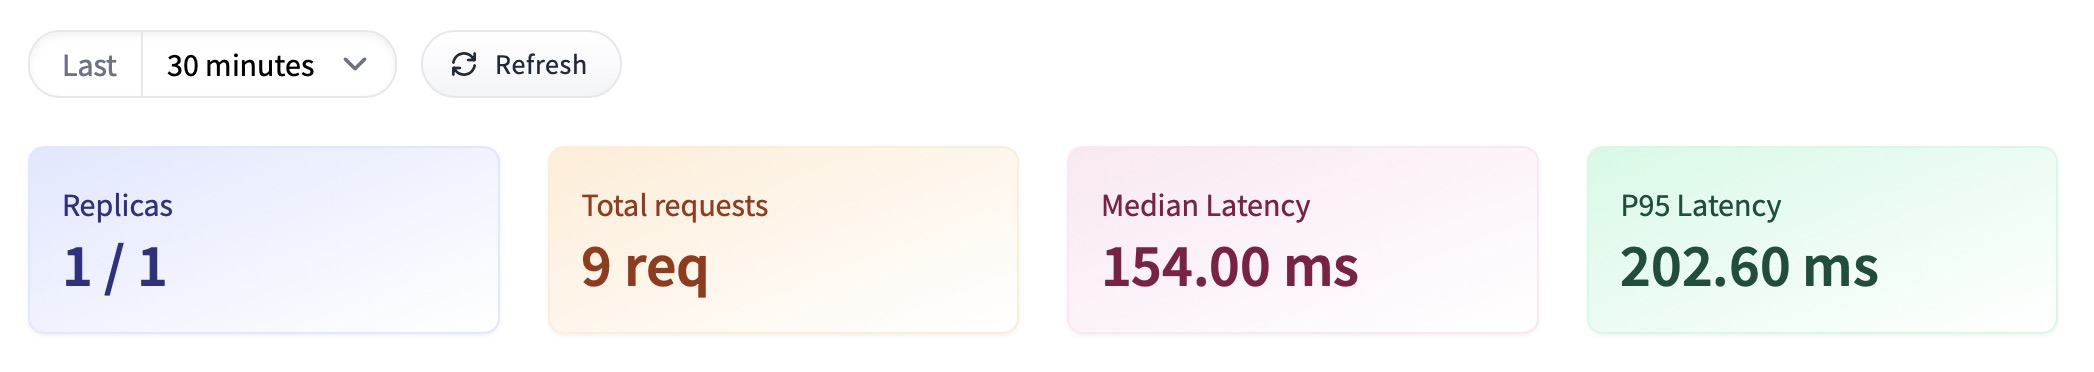


#### Embedding Endpoint Analytics
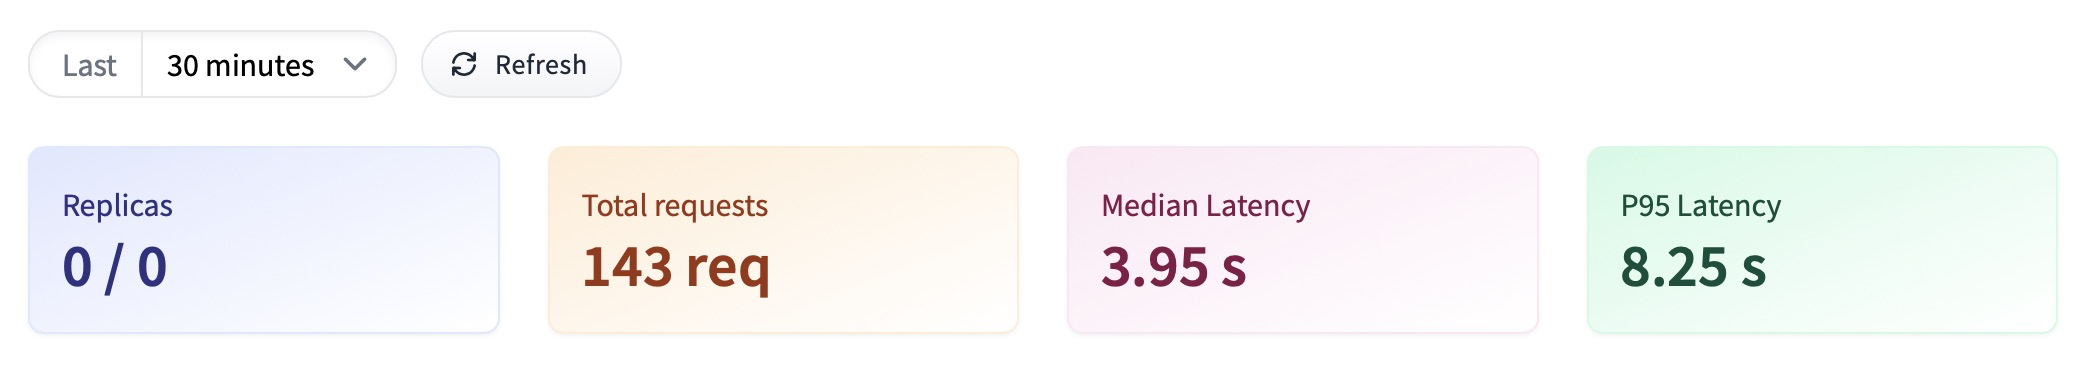